In [2]:
import sys
sys.path.append('..')
import h5py
import h5py
import numpy as np
from numpy import einsum
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

import configparser
import os
from os.path import join as pjoin
from pathlib import Path
import json

import tensorflow as tf
tf.keras.backend.set_floatx('float32')
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
mse = MeanSquaredError()

import MD_AE_tools.models.models as mdl_bias
import MD_AE_tools.models.models_no_bias as mdl_nobias
from project_specific_utils.helpers import GetAttr
import MD_AE_tools.mode_decomposition as md
import MD_AE_tools.ae_mode_selection as ranking
import MD_AE_tools.ae_mode_evaluation as mode_eval
from project_specific_utils.data_and_train import TrainNN_from_config, train_autoencder
from project_specific_utils import plot as myplot

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')# use [] for cpu only, gpus[i] for the ith gpu
        tf.config.set_logical_device_configuration(gpus[0], [tf.config.LogicalDeviceConfiguration(memory_limit=1024)]) 
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

2022-08-30 09:46:24.806958: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-30 09:46:24.806988: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-30 09:46:24.807005: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ic-5rpzl43): /proc/driver/nvidia/version does not exist


# Linear MD-CNN-AE

In [ ]:
parent_folder = '/home/ym917/Documents/Results/experiment_linear_samedata'
!ls -v $parent_folder

In [ ]:
folder = 'ufluc_nobias26-1751814'
folder_path = pjoin(parent_folder,folder)
filename = pjoin(folder_path,'training_param.ini')
linear = TrainNN_from_config(filename)

filename = pjoin(folder_path,'results.h5')
with h5py.File(filename,'r') as hf:
    u_train = np.array(hf.get('u_train'))
    u_all = np.array(hf.get('u_all'))
    y_train = np.array(hf.get('y_train'))
    modes_train = np.array(hf.get('modes_train'))
    latent_train = np.array(hf.get('latent_train'))

print('MSE of traning is: ', mse(u_train,y_train).numpy())

In [ ]:
# calculate data POD
x = einsum('t y z u -> y z t u',np.squeeze(u_train))
X = np.vstack((x[:,:,:,0],x[:,:,:,1]))
pod = md.POD(X)
Q_POD,lam_data = pod.get_modes
Q_mean = pod.Q_mean
X_reconstructed = pod.reconstruct(2,shape=X.shape)
print('MSE reconstructed with 2 modes is: ', mse(X,X_reconstructed).numpy())

# plot data POD
phi1 = Q_POD[:,0].reshape((42,24))
phi2 = Q_POD[:,1].reshape((42,24))
fig = plt.figure(facecolor='white')
fig.suptitle('POD modes of the training set')
plt.subplot(221,xticks=[],yticks=[],title='mode 1',ylabel='v')
plt.imshow(phi1[:21,:],'jet')
plt.colorbar()
plt.subplot(223,xticks=[],yticks=[],ylabel='w')
plt.imshow(phi1[21:,:],'jet')
plt.colorbar()
plt.subplot(222,xticks=[],yticks=[],title='mode 2')
plt.imshow(phi2[:21,:],'jet')
plt.colorbar()
plt.subplot(224,xticks=[],yticks=[])
plt.imshow(phi2[21:,:],'jet')
plt.colorbar()

u_train_mean = np.mean(np.squeeze(u_train),axis=0)
fig2 = plt.figure()
fig2.suptitle('mean of the training set')
ax = ImageGrid(fig2, 111, (1,2), share_all=True, axes_pad=0.3, cbar_location='right', cbar_mode='each', cbar_pad=0.03)
cax = ax.cbar_axes
ax[0].set(xticks=[],yticks=[],title='v')
ax[1].set_title('w')
im1 = ax[0].imshow(u_train_mean[:,:,0],'jet')
cax[0].colorbar(im1)
im2 = ax[1].imshow(u_train_mean[:,:,1],'jet')
cax[1].colorbar(im2)

plt.show()

In [ ]:
# modes without bias
if linear.NO_BIAS:
    modes_train_nobias = modes_train
elif linear.NO_BIAS is False:
    mdl = mdl_bias.Autoencoder(linear.Nx,linear.Nu,linear.features_layers,linear.latent_dim,linear.filter_window, linear.act_fct, linear.BATCH_NORM, linear.drop_rate, linear.lmb, )
    mdl.compile(optimizer=Adam(learning_rate=linear.learning_rate),loss='mse')
    _ = mdl.predict(np.squeeze(u_train))
    filename = pjoin(folder_path,'md_ae_model.h5')
    mdl.load_weights(filename)

    bias = mdl.decoder.predict(np.zeros((1,linear.latent_dim)))
    modes_train_nobias = modes_train - np.squeeze(bias)
    w1 = mdl.decoder.predict(np.reshape([1,0],(1,2))) - bias
    w2 = mdl.decoder.predict(np.reshape([0,1],(1,2))) - bias

In [ ]:
print(w1.shape)
print(Q_POD.shape)
x_train = einsum('t y z u -> y z t u',w1)
X_train = np.vstack((x_train[:,:,:,0],x_train[:,:,:,1]))
X_train = np.reshape(X_train,(-1,1))
A = einsum('x t, x m -> t m', X_train, Q_POD) # project
lam_1 = einsum('t m -> m',A**2) / lam_data
print(lam_1)
plt.figure()
plt.plot(lam_1)
plt.xlim([0,10])
plt.show()

In [ ]:
# reproject autoencoder modes onto data pod modes
x_axis = np.arange(1,linear.Nz*linear.Ny*linear.Nu+1)

lam_modes = mode_eval.equivalent_pca_energy(modes_train_nobias,Q_POD)
lam_modes_percent = lam_modes/lam_data

plt.figure()
plt.suptitle('Equivalent PCA energy')
for i in range(linear.latent_dim):
    plt.plot(x_axis,lam_modes[i,:],label=i+1,linestyle='--',marker='x')
plt.plot(x_axis,lam_data,label='data')
plt.xlim([1,5])
plt.xticks(range(5))
plt.ylim(bottom=0)
plt.ylabel('variance on the POD axis (eigenvalues)')
plt.xlabel('POD mode')
plt.legend()

# Similarity between time coeffcient and latent variables
A = pod.get_time_coefficient #(nt, nx)
mag_A = einsum('t x -> x',A**2)**0.5

plt.figure()
plt.suptitle('cosine of the angle between the latent variables and POD time coefficient (as time series)')
plt.xlabel('POD mode')
plt.ylabel('|cos(angle_z&A)|')
for i in range(linear.latent_dim):
    mag_z = np.sum(latent_train[:,i]**2)**0.5
    divisor = mag_A * mag_z
    z_dot_A = latent_train[:,[i]].T @ A
    cos_angle = (z_dot_A / divisor).flatten()
    plt.plot(x_axis,np.abs(cos_angle),label=str(i+1))
plt.xlim([0,10])
plt.legend()



plt.show()

# Nonlinear

In [2]:
parent_folder = '/home/ym917/Documents/Results/experiment_nonlinear'
!ls -v $parent_folder
folder_list = ! ls -v $parent_folder
# !tail -n 5 $parent_folder/*/log

0808_2mode1-2894758  0808_2mode5-2894762  0808_2mode9-2894766
0808_2mode2-2894759  0808_2mode6-2894763  0808_2mode10-2894767
0808_2mode3-2894760  0808_2mode7-2894764  grouping_modes_1.csv
0808_2mode4-2894761  0808_2mode8-2894765  grouping_modes_2.csv


In [22]:
# folder = '0808_2mode5-2894762'
folder = '0808_2mode3-2894760'
folder_path = pjoin(parent_folder,folder)
filename = pjoin(folder_path,'training_param.ini')
nonlinear = TrainNN_from_config(filename)

filename = pjoin(folder_path,'results.h5')
with h5py.File(filename,'r') as hf:
    u_train = np.array(hf.get('u_train'))
    u_all = np.array(hf.get('u_all'))
    y_train = np.array(hf.get('y_train'))
    modes_train = np.array(hf.get('modes_train'))
    modes_test = np.array(hf.get('modes_test'))
    latent_train = np.array(hf.get('latent_train'))
    latent_test = np.array(hf.get('latent_test'))

print('MSE of traning is: ', mse(u_train,y_train).numpy())

MSE of traning is:  1.3582834


Calculating POD ...
Use classic POD, Nx <= Nt.
POD done.
MSE reconstructed with 2 modes is:  1.4777343273162842


/home/ym917/Documents/Codes/MD-CNN-AE/MD_AE_tools/mode_decomposition.py:220: RuntimeWarning: invalid value encountered in sqrt
  normQ = (Q_POD.T @ Q_POD*self.w).real**0.5


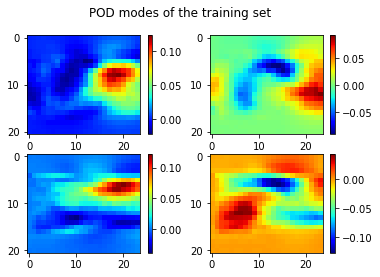

In [23]:
## data 
x = einsum('t y z u -> y z t u',np.squeeze(u_train))
X = np.vstack((x[:,:,:,0],x[:,:,:,1]))
pod = md.POD(X)
Q_POD,lam_data = pod.get_modes
Q_mean = pod.Q_mean
X_reconstructed = pod.reconstruct(2,shape=X.shape)
print('MSE reconstructed with 2 modes is: ', mse(X,X_reconstructed).numpy())

phi1 = Q_POD[:,0].reshape((42,24))
phi2 = Q_POD[:,1].reshape((42,24))
fig = plt.figure()
fig.suptitle('POD modes of the training set')
plt.subplot(221)
plt.imshow(phi1[:21,:],'jet')
plt.colorbar()
plt.subplot(223)
plt.imshow(phi1[21:,:],'jet')
plt.colorbar()
plt.subplot(222)
plt.imshow(phi2[:21,:],'jet')
plt.colorbar()
plt.subplot(224)
plt.imshow(phi2[21:,:],'jet')
plt.colorbar()
plt.show()

In [24]:
# reproject autoencoder modes onto data pod modes
lam_modes = mode_eval.equivalent_pca_energy(modes_train,Q_POD)
lam_modes_percent = lam_modes/lam_data

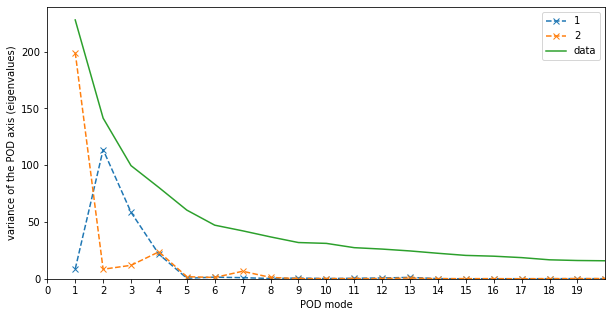

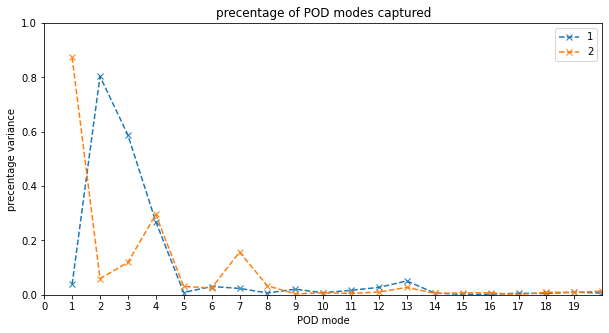

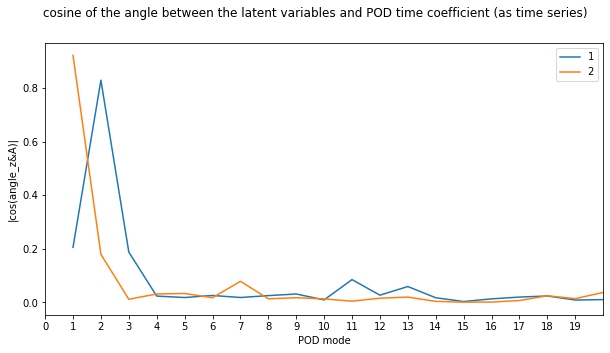

In [25]:
x_axis = np.arange(1,nonlinear.Nz*nonlinear.Ny*nonlinear.Nu+1)

plt.figure(figsize=(10,5))
for i in range(nonlinear.latent_dim):
    plt.plot(x_axis,lam_modes[i,:],label=i+1,linestyle='--',marker='x')
plt.plot(x_axis,lam_data,label='data')
plt.xlim([0,20])
plt.xticks(range(20))
plt.ylim(bottom=0)
plt.ylabel('variance of the POD axis (eigenvalues)')
plt.xlabel('POD mode')
plt.legend()

plt.figure(figsize=(10,5))
for i in range(nonlinear.latent_dim):
    plt.plot(x_axis,lam_modes_percent[i,:],label=i+1,linestyle='--',marker='x')
plt.xlim([0,20])
plt.ylim([0,1])
plt.xticks(range(20))
plt.legend()
plt.xlabel('POD mode')
plt.ylabel('precentage variance')
plt.title('precentage of POD modes captured')


# Similarity between time coeffcient and latent variables
A = pod.get_time_coefficient #(nt, nx)
mag_A = einsum('t x -> x',A**2)**0.5

plt.figure(figsize=(10,5))
plt.suptitle('cosine of the angle between the latent variables and POD time coefficient (as time series)')
plt.xlabel('POD mode')
plt.ylabel('|cos(angle_z&A)|')
for i in range(nonlinear.latent_dim):
    mag_z = np.sum(latent_train[:,i]**2)**0.5
    divisor = mag_A * mag_z
    z_dot_A = latent_train[:,[i]].T @ A
    cos_angle = (z_dot_A / divisor).flatten()
    plt.plot(x_axis, np.abs(cos_angle),label=str(i+1))
plt.xlim([0,20])
plt.xticks(range(20))
plt.legend()


plt.show()

### Do not run unless needed

#### Re-train

In [ ]:
mdl = mdl_nobias.MD_Autoencoder(Nx=nonlinear.Nx,Nu=nonlinear.Nu,
                            features_layers=nonlinear.features_layers,
                            latent_dim=nonlinear.latent_dim,
                            filter_window=nonlinear.filter_window,
                            act_fct=nonlinear.act_fct,
                            batch_norm=nonlinear.BATCH_NORM,
                            drop_rate=nonlinear.drop_rate,
                            lmb=nonlinear.lmb,
                            resize_meth=nonlinear.resize_meth)
mdl.compile(optimizer=Adam(learning_rate=nonlinear.learning_rate),loss='mse')
mdl.evaluate(np.squeeze(u_train),np.squeeze(u_train))

# ==============================================
# filename = Path(folder_path,'md_ae_model.h5')
filename = 'temp.h5'
mdl.load_weights(filename)
# ===============================================

mdl.evaluate(np.squeeze(u_train),np.squeeze(u_train))

model_cb=ModelCheckpoint('temp.h5', monitor='loss',save_best_only=True,verbose=1,save_weights_only=True)#'val_loss or loss
early_cb=EarlyStopping(monitor='loss', patience=200,verbose=1)
cb = [model_cb, early_cb]

filename = Path(folder_path,'results.h5')
with h5py.File(filename,'r') as hf:
    u_train = np.array(hf.get('u_train'))
    u_val = np.array(hf.get('u_val'))
    u_test = np.array(hf.get('u_test'))

hist_train, hist_val, mse_test, time_info = train_autoencder(mdl, (u_train,u_val,u_test), nonlinear.batch_size , 1000, cb, save_model_to='temp.h5')

decoders = mdl.get_decoders()
coded_train = mdl.encoder.predict(np.squeeze(u_train,axis=0)) #(time,mode)
mode_train = []
for i in range(nonlinear.latent_dim):
    z = coded_train[:,i]
    z = np.reshape(z,(-1,1))
    mode_train.append(decoders[i].predict(z))
mode_train = np.array(mode_train)

# equivalent pca
lam_modes = mode_eval.equivalent_pca_energy(mode_train,Q_POD)
lam_modes_percent = lam_modes/lam_data

plt.figure(figsize=(10,5))
for i in range(nonlinear.latent_dim):
    plt.plot(x_axis,lam_modes[i,:],label=i+1,linestyle='--',marker='x')
plt.plot(x_axis,lam_data,label='data')
plt.xlim([0,20])
plt.xticks(range(20))
plt.ylim(bottom=0)
plt.ylabel('variance of the POD axis (eigenvalues)')
plt.xlabel('POD mode')
plt.legend()

In [ ]:
import project_specific_utils.md_cnn_ae as aeplot
aeplot.plot_autoencoder_modes(2,modes_train,0)
aeplot.plot_autoencoder_modes(2,mode_train,0)
print('MSE of traning is: ', mse(u_train,mdl.predict(np.squeeze(u_train))).numpy())

#### save to CSV

In [ ]:
parent_folder = '/home/ym917/Documents/Results/experiment_nonlinear'
!ls -v $parent_folder
folder_list = ! ls -v $parent_folder

In [ ]:
# with h5py.File('./data/ufluc_shuffle_1632.h5') as hf:
#     u_train = np.array(hf.get('u_train'))
# x = einsum('t y z u -> y z t u',np.squeeze(u_train))
# X = np.vstack((x[:,:,:,0],x[:,:,:,1]))
# pod = md.POD(X)
# Q_POD,lam_data = pod.get_modes
# Q_mean = pod.Q_mean
# X_reconstructed = pod.reconstruct(2,shape=X.shape)
# print('MSE reconstructed with 2 modes is: ', mse(X,X_reconstructed).numpy())


# for i in folder_list:
#     folder_path = Path(parent_folder,i)

#     filename = Path(folder_path, 'training_param.ini')
#     nonlinear = TrainNN_from_config(filename)

#     filename = Path(folder_path,'results.h5')
#     with h5py.File(filename,'r') as hf:
#         u_train = np.array(hf.get('u_train'))
#         y_train = np.array(hf.get('y_train'))
#         modes_train = np.array(hf.get('modes_train'))
#     print('MSE of traning is: ', mse(u_train,y_train).numpy())

#     lam_modes = mode_eval.equivalent_pca_energy(modes_train,Q_POD)
#     lam_modes_percent = lam_modes/lam_data
#     x_axis = np.arange(1,nonlinear.Nz*nonlinear.Ny*nonlinear.Nu+1)

#     # save reporjected results to csv

#     csv1 = Path(parent_folder,'grouping_modes_1.csv')
#     csv2 = Path(parent_folder,'grouping_modes_2.csv')
#     with open(csv1,'a') as f1, open(csv2,'a') as f2:
#         if lam_modes[0,0] > lam_modes[1,0]:
#             np.savetxt(f1,lam_modes_percent[[0],:],delimiter=',')
#             np.savetxt(f2,lam_modes_percent[[1],:],delimiter=',')
#         elif lam_modes[1,0] > lam_modes[0,0]:
#             np.savetxt(f1,lam_modes_percent[[1],:],delimiter=',')
#             np.savetxt(f2,lam_modes_percent[[0],:],delimiter=',')


In [ ]:
## save reporjected results to csv

# csv1 = pjoin(parent_folder,'grouping_modes_1.csv')
# csv2 = pjoin(parent_folder,'grouping_modes_2.csv')
# with open(csv1,'a') as f1, open(csv2,'a') as f2:
#     if lam_modes[0,0] > lam_modes[1,0]:
#         np.savetxt(f1,lam_modes_percent[[0],:],delimiter=',')
#         np.savetxt(f2,lam_modes_percent[[1],:],delimiter=',')
#     elif lam_modes[1,0] > lam_modes[0,0]:
#         np.savetxt(f1,lam_modes_percent[[1],:],delimiter=',')
#         np.savetxt(f2,lam_modes_percent[[0],:],delimiter=',')

#### From CSV, calculate average

In [15]:
## load reprojected results from csv
csv1 = pjoin(parent_folder,'grouping_modes_1.csv')
csv2 = pjoin(parent_folder,'grouping_modes_2.csv')

lam_modes_total1 = np.loadtxt(csv1, delimiter=',')
lam_modes_total2 = np.loadtxt(csv2, delimiter=',')

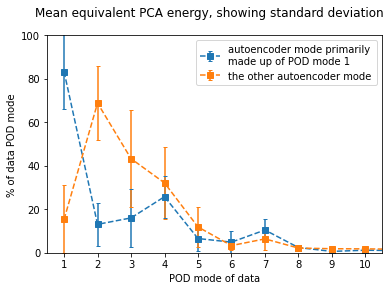

In [16]:
l1_mean = np.mean(lam_modes_total1,axis=0)
l1_std = np.std(lam_modes_total1,axis=0)
l2_mean = np.mean(lam_modes_total2,axis=0)
l2_std = np.std(lam_modes_total2,axis=0)


fig, ax = plt.subplots(1,sharex=True,sharey=True)
fig.suptitle('Mean equivalent PCA energy, showing standard deviation')
ax.errorbar(np.arange(1,len(l1_mean+1)+1),l1_mean*100, yerr=l1_std*100, fmt='s', capsize=2, linestyle='--', label='autoencoder mode primarily \nmade up of POD mode 1')
ax.set_xticks(np.arange(1,len(l1_mean+1)+1))
ax.set_xlim([0.5,10.5])
ax.set_ylim([0,100])
ax.errorbar(np.arange(1,len(l1_mean+1)+1),l2_mean*100, yerr=l2_std*100, fmt='s', capsize=2, linestyle='--', label='the other autoencoder mode')
ax.set_ylabel("% of data POD mode")
ax.set_xlabel('POD mode of data')
plt.legend()
plt.show()

# plt.show()

### Ranking

In [5]:
# ke, mse, iterative mse, signal_energy
_, rank_ke = ranking.kinetic_energy_ae_modes(modes_train)
rank_mse_individual = ranking.best_mse_individual(modes_train, np.squeeze(u_train))
rank_mse_combined = ranking.best_mse_combined(modes_train,np.squeeze(u_train))
_,_,rank_signal_energy = ranking.rms_amplitude(latent_train)
print('rank_mse_individual: ',rank_mse_individual)
print('rank_mse_combined:   ',rank_mse_combined)
print('rank_ke:             ',rank_ke)
print('rank_signal_energy:  ',rank_signal_energy)

rank_mse_individual:  [1 0]
rank_mse_combined:    [1 0]
rank_ke:              [0 1]
rank_signal_energy:   [1 0]


### Relationships

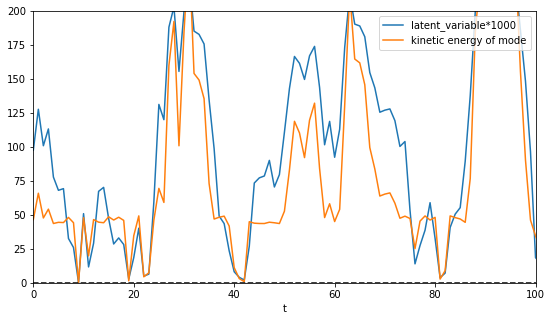

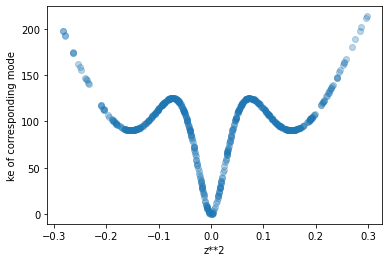

correlation coefficient 0.5590508261374999


In [37]:
ke = 0.5 * np.einsum('z t x y u -> z t', modes_test**2)
plt.figure(figsize=(9,5))
plt.plot(np.abs(latent_test[:,1]*1000), label='latent_variable*1000')
plt.plot(ke[1,:], label='kinetic energy of mode')
plt.axhline(y=0, color='k', linestyle='--')
plt.legend()
plt.xlabel('t')
plt.ylim([0,0.2*1000])
plt.xlim([0,100])

plt.figure()
plt.scatter(latent_test[:,0], ke[0,:], alpha=0.3)
plt.xlabel('z**2')
plt.ylabel('ke of corresponding mode')
plt.show()

print('correlation coefficient', np.corrcoef(np.abs(latent_test[:,0]**2), ke[0,:])[0,1])

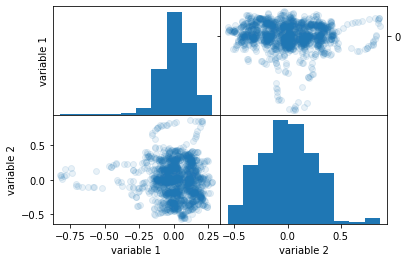

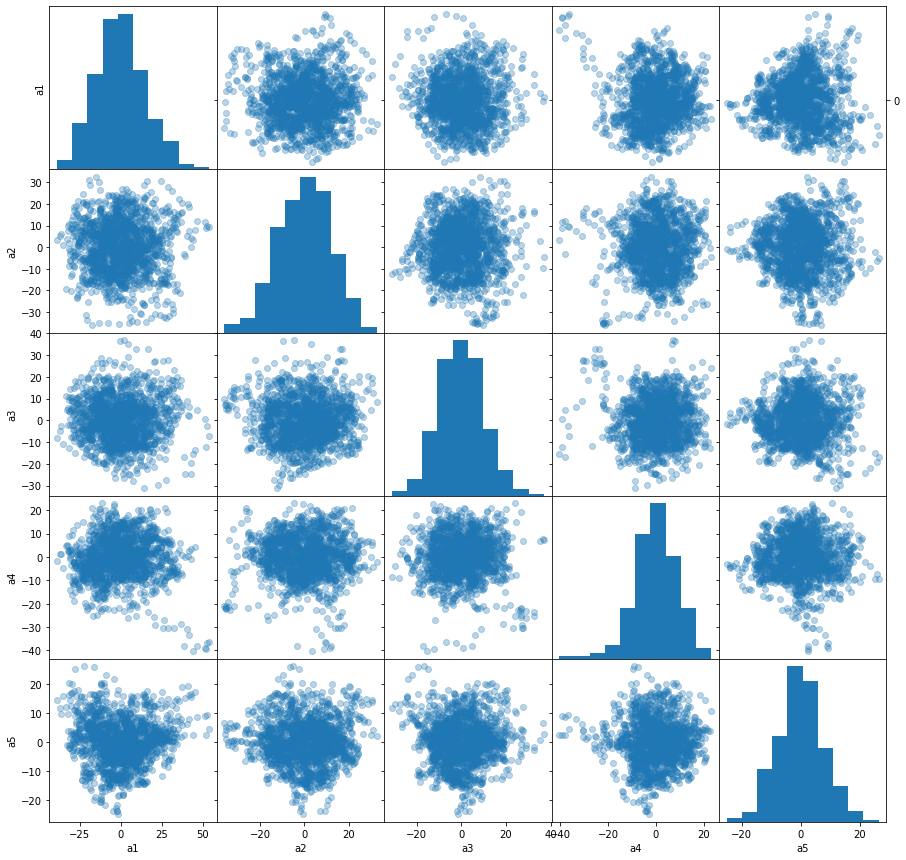

In [20]:
# scatter matrix
fig1, ax1 = myplot.scatter_matrix(latent_train, variable_names=['variable 1', 'variable 2'], kwargs_scatter={'alpha':0.1})
fig2, ax2 = myplot.scatter_matrix(A[:,:5], variable_names=['a1', 'a2', 'a3', 'a4', 'a5'], kwargs_scatter={'alpha':0.3}, kwargs_figure={'figsize':(15,15)})
plt.show()